In [1]:
#imports and paths
import sys
from pathlib import Path

# Add project root
ROOT = Path.cwd().parent   # notebooks/ → project root
sys.path.append(str(ROOT))

print("Using ROOT:", ROOT)

import torch
from torch.utils.data import DataLoader, Subset
import json
from sklearn.model_selection import train_test_split

from src.datasets import MultiLabelSceneDataset
from src.simclr import SimCLRModel
from src.finetune import MultiLabelFineTune


Using ROOT: /home/syed-mohammed-bilal/projects/office-ssl


/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


In [2]:
#set device and paths
device = 'cuda' if torch.cuda.is_available() else 'cpu'

BASE = Path.home() / "projects/office-ssl"
LABELED = BASE / "data/labeled"

IMG_DIR = LABELED / "images"
ANNOT_CSV = LABELED / "annotations.csv"
LABEL_MAP = LABELED / "label_map.json"
CKPT_DIR = BASE / "checkpoints"

label_map = json.load(open(LABEL_MAP))
num_classes = len(label_map)


In [3]:
#loading dataset and dataloaders
train_ds = MultiLabelSceneDataset(IMG_DIR, ANNOT_CSV, LABEL_MAP)

indices = list(range(len(train_ds)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_dl = DataLoader(Subset(train_ds, train_idx), batch_size=16, shuffle=True,
                      num_workers=4, pin_memory=True)
val_dl   = DataLoader(Subset(train_ds, val_idx), batch_size=32, shuffle=False,
                      num_workers=4, pin_memory=True)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Classes: {num_classes}")


Train: 400, Val: 100, Classes: 19


In [4]:
#Load SimCLR Backbone (PRETRAINED FROM STEP 1)
simclr_ckpt = sorted(CKPT_DIR.glob("simclr-epoch*.ckpt"))[-1]
print("Loading SimCLR backbone from:", simclr_ckpt)

simclr = SimCLRModel.load_from_checkpoint(str(simclr_ckpt), strict=False)
backbone = simclr.backbone.to(device)
backbone.eval()


Loading SimCLR backbone from: /home/syed-mohammed-bilal/projects/office-ssl/checkpoints/simclr-epoch=99-train_loss=3.8704.ckpt


/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
#creating fine-tune model
model = MultiLabelFineTune(
    backbone=backbone,
    num_classes=num_classes,
    lr=1e-4,
    freeze_backbone=False
).to(device)


In [6]:
#training model
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("logs", name="finetune_clean")
ckpt_cb = ModelCheckpoint(
    dirpath=str(CKPT_DIR),
    filename="finetune-{epoch:02d}-{val_mAP_mean:.4f}",
    save_top_k=3,
    monitor="val/mAP_mean",
    mode="max",
    auto_insert_metric_name=False
)
early_stop = EarlyStopping(monitor="val/mAP_mean", patience=8, mode="max")

trainer = Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    max_epochs=50,
    precision=16,
    callbacks=[ckpt_cb, early_stop, LearningRateMonitor(logging_interval='epoch')],
    logger=logger
)

trainer.fit(model, train_dl, val_dl)


Using 16bit None Automatic Mixed Precision (AMP)
/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/pytorch_lightning/plugins/precision/native_amp.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_c

Sanity Checking DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.73it/s]
Epoch done — val_mAP_mean=0.1695, F1=0.1595, Hamming=0.5016
                                                                                                                                                                                                                                      

/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 25/29 [00:03<00:00,  7.32it/s, loss=0.393, v_num=1, train/loss_step=0.339]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.27it/s, loss=0.393, v_num=1, train/loss_step=0.339]
Epoch done — val_mAP_mean=0.2964, F1=0.0000, Hamming=0.1205
Epoch 1:  86%|██████████████████████████████████████████████████▊        | 25/29 [00:03<00:00,  7.26it/s, loss=0.379, v_num=1, train/loss_step=0.319, val/mAP_mean=0.296, val/f1_macro=0.000, train/loss_epoch=0.420, train/mAP=0.161]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.26it/s, loss=0.379, v_num=1, train/loss_step=0.319, val/mAP_mean=0.296, val/f1_macro=0.

In [7]:
#loading best fine-tuned checkpoints
best_ckpt = ckpt_cb.best_model_path
print("Best checkpoint:", best_ckpt)

# Recreate backbone
simclr = SimCLRModel.load_from_checkpoint(str(simclr_ckpt))
backbone = simclr.backbone.to(device).eval()

# Recreate model
finetuned = MultiLabelFineTune(
    backbone=backbone,
    num_classes=num_classes
).to(device)

# Load state_dict
state = torch.load(best_ckpt, map_location=device)["state_dict"]
clean = {k: v for k, v in state.items() if k.startswith("backbone.") or k.startswith("classifier.")}
finetuned.load_state_dict(clean, strict=False)
finetuned.eval()


Best checkpoint: /home/syed-mohammed-bilal/projects/office-ssl/checkpoints/finetune-12-0.0000.ckpt


/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

MultiLabelFineTune(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [8]:
#evaluation
import torch
import numpy as np

finetuned.eval()
all_logits = []
all_targets = []

with torch.no_grad():
    for x, y in val_dl:
        x = x.to(device)
        y = y.to(device)

        logits = finetuned(x)
        all_logits.append(logits.cpu())
        all_targets.append(y.cpu())

all_logits = torch.cat(all_logits)
all_targets = torch.cat(all_targets)

all_probs = torch.sigmoid(all_logits).numpy()
targets = all_targets.numpy()

print("Shapes:", all_probs.shape, targets.shape)


Shapes: (100, 19) (100, 19)


In [9]:
#Compute Metrics (mAP, F1, Hamming Loss)
from sklearn.metrics import average_precision_score, f1_score, hamming_loss

# Per-class AP
aps = []
for c in range(num_classes):
    aps.append(average_precision_score(targets[:, c], all_probs[:, c]))

mean_ap = np.nanmean(aps)

# Use default threshold = 0.5 for first F1 check
preds_05 = (all_probs >= 0.5).astype(int)
macro_f1 = f1_score(targets, preds_05, average="macro", zero_division=0)
hl = hamming_loss(targets, preds_05)

print("Mean AP:", mean_ap)
print("Macro-F1 @0.5:", macro_f1)
print("Hamming Loss:", hl)


Mean AP: 0.3614499481789287
Macro-F1 @0.5: 0.08265110543503895
Hamming Loss: 0.11842105263157894


In [10]:
#Confidence Calibration (Per-Class Optimal Thresholds)
best_thresh = []
for c in range(num_classes):
    best_t = 0.5
    best_f1 = 0
    for t in np.linspace(0.05, 0.5, 50):
        pred_t = (all_probs[:, c] >= t).astype(int)
        f1 = f1_score(targets[:, c], pred_t, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresh.append(best_t)

best_thresh = np.array(best_thresh)
print("Optimal thresholds:", np.round(best_thresh, 4))
print("Mean optimal threshold:", best_thresh.mean())


Optimal thresholds: [0.2612 0.2153 0.1327 0.151  0.3255 0.1051 0.0776 0.1327 0.1878 0.3806
 0.0867 0.1418 0.4357 0.1878 0.1235 0.2704 0.0959 0.252  0.2245]
Mean optimal threshold: 0.19935553168635878


In [11]:
#computing f1 with calibrated thresholds
preds_opt = (all_probs >= best_thresh).astype(int)
f1_opt = f1_score(targets, preds_opt, average="macro", zero_division=0)
print("Macro-F1 (optimal thresholds):", f1_opt)


Macro-F1 (optimal thresholds): 0.42934537625754826


In [12]:
#class frequencies
import pandas as pd
annot = pd.read_csv(ANNOT_CSV)
freqs = annot['labels'].str.split(';').explode().value_counts()
print(freqs)

labels
pam_beesly         90
kevin_malone       88
angela_martin      84
oscar_martinez     80
dwight_schrute     79
stanley_hudson     76
phyllis_vance      75
others             74
meredith_palmer    73
jim_halpert        72
creed_bratton      60
erin_hannon        60
michael_scott      58
toby_flenderson    57
andy_bernard       51
kelly_kapoor       48
ryan_howard        48
darryl_philbin     40
nellie_bertram     30
Name: count, dtype: int64


In [13]:
#saving final calibrated model
SAVE_PATH = BASE / "final_model.pth"

torch.save({
    "state_dict": finetuned.state_dict(),
    "thresholds": best_thresh,
    "label_map": label_map,
}, SAVE_PATH)

print("Saved ", SAVE_PATH)


Saved  /home/syed-mohammed-bilal/projects/office-ssl/final_model.pth


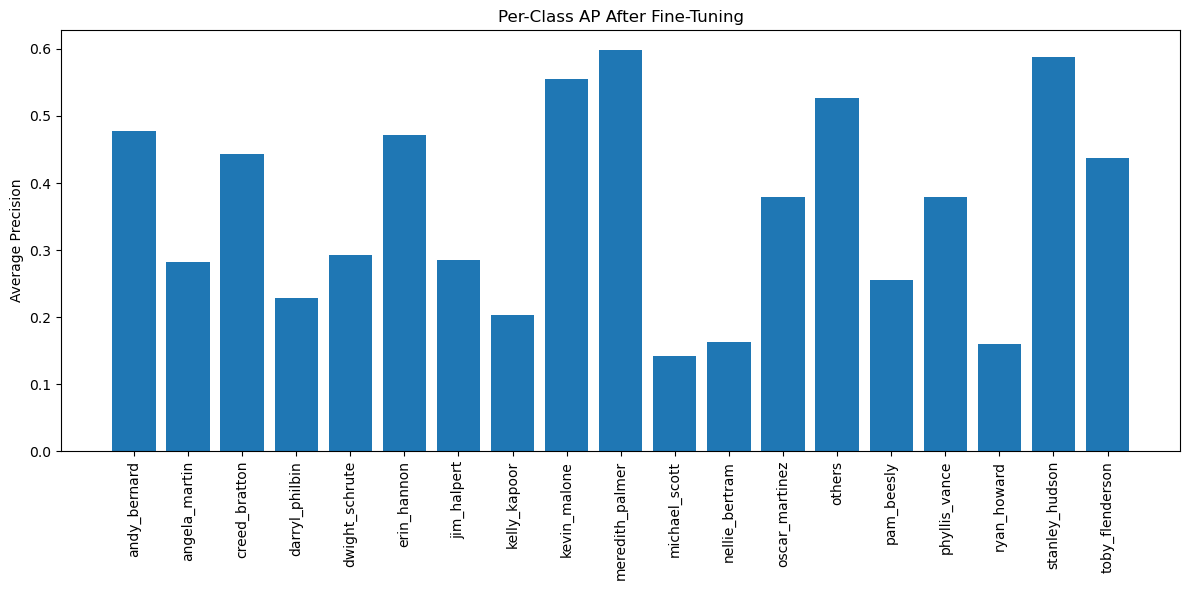

In [14]:
#Per-Class AP Bar Chart
import matplotlib.pyplot as plt
import numpy as np

names = [k for k in label_map.keys()]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(num_classes), aps)
plt.xticks(np.arange(num_classes), names, rotation=90)
plt.ylabel("Average Precision")
plt.title("Per-Class AP After Fine-Tuning")
plt.tight_layout()
plt.show()


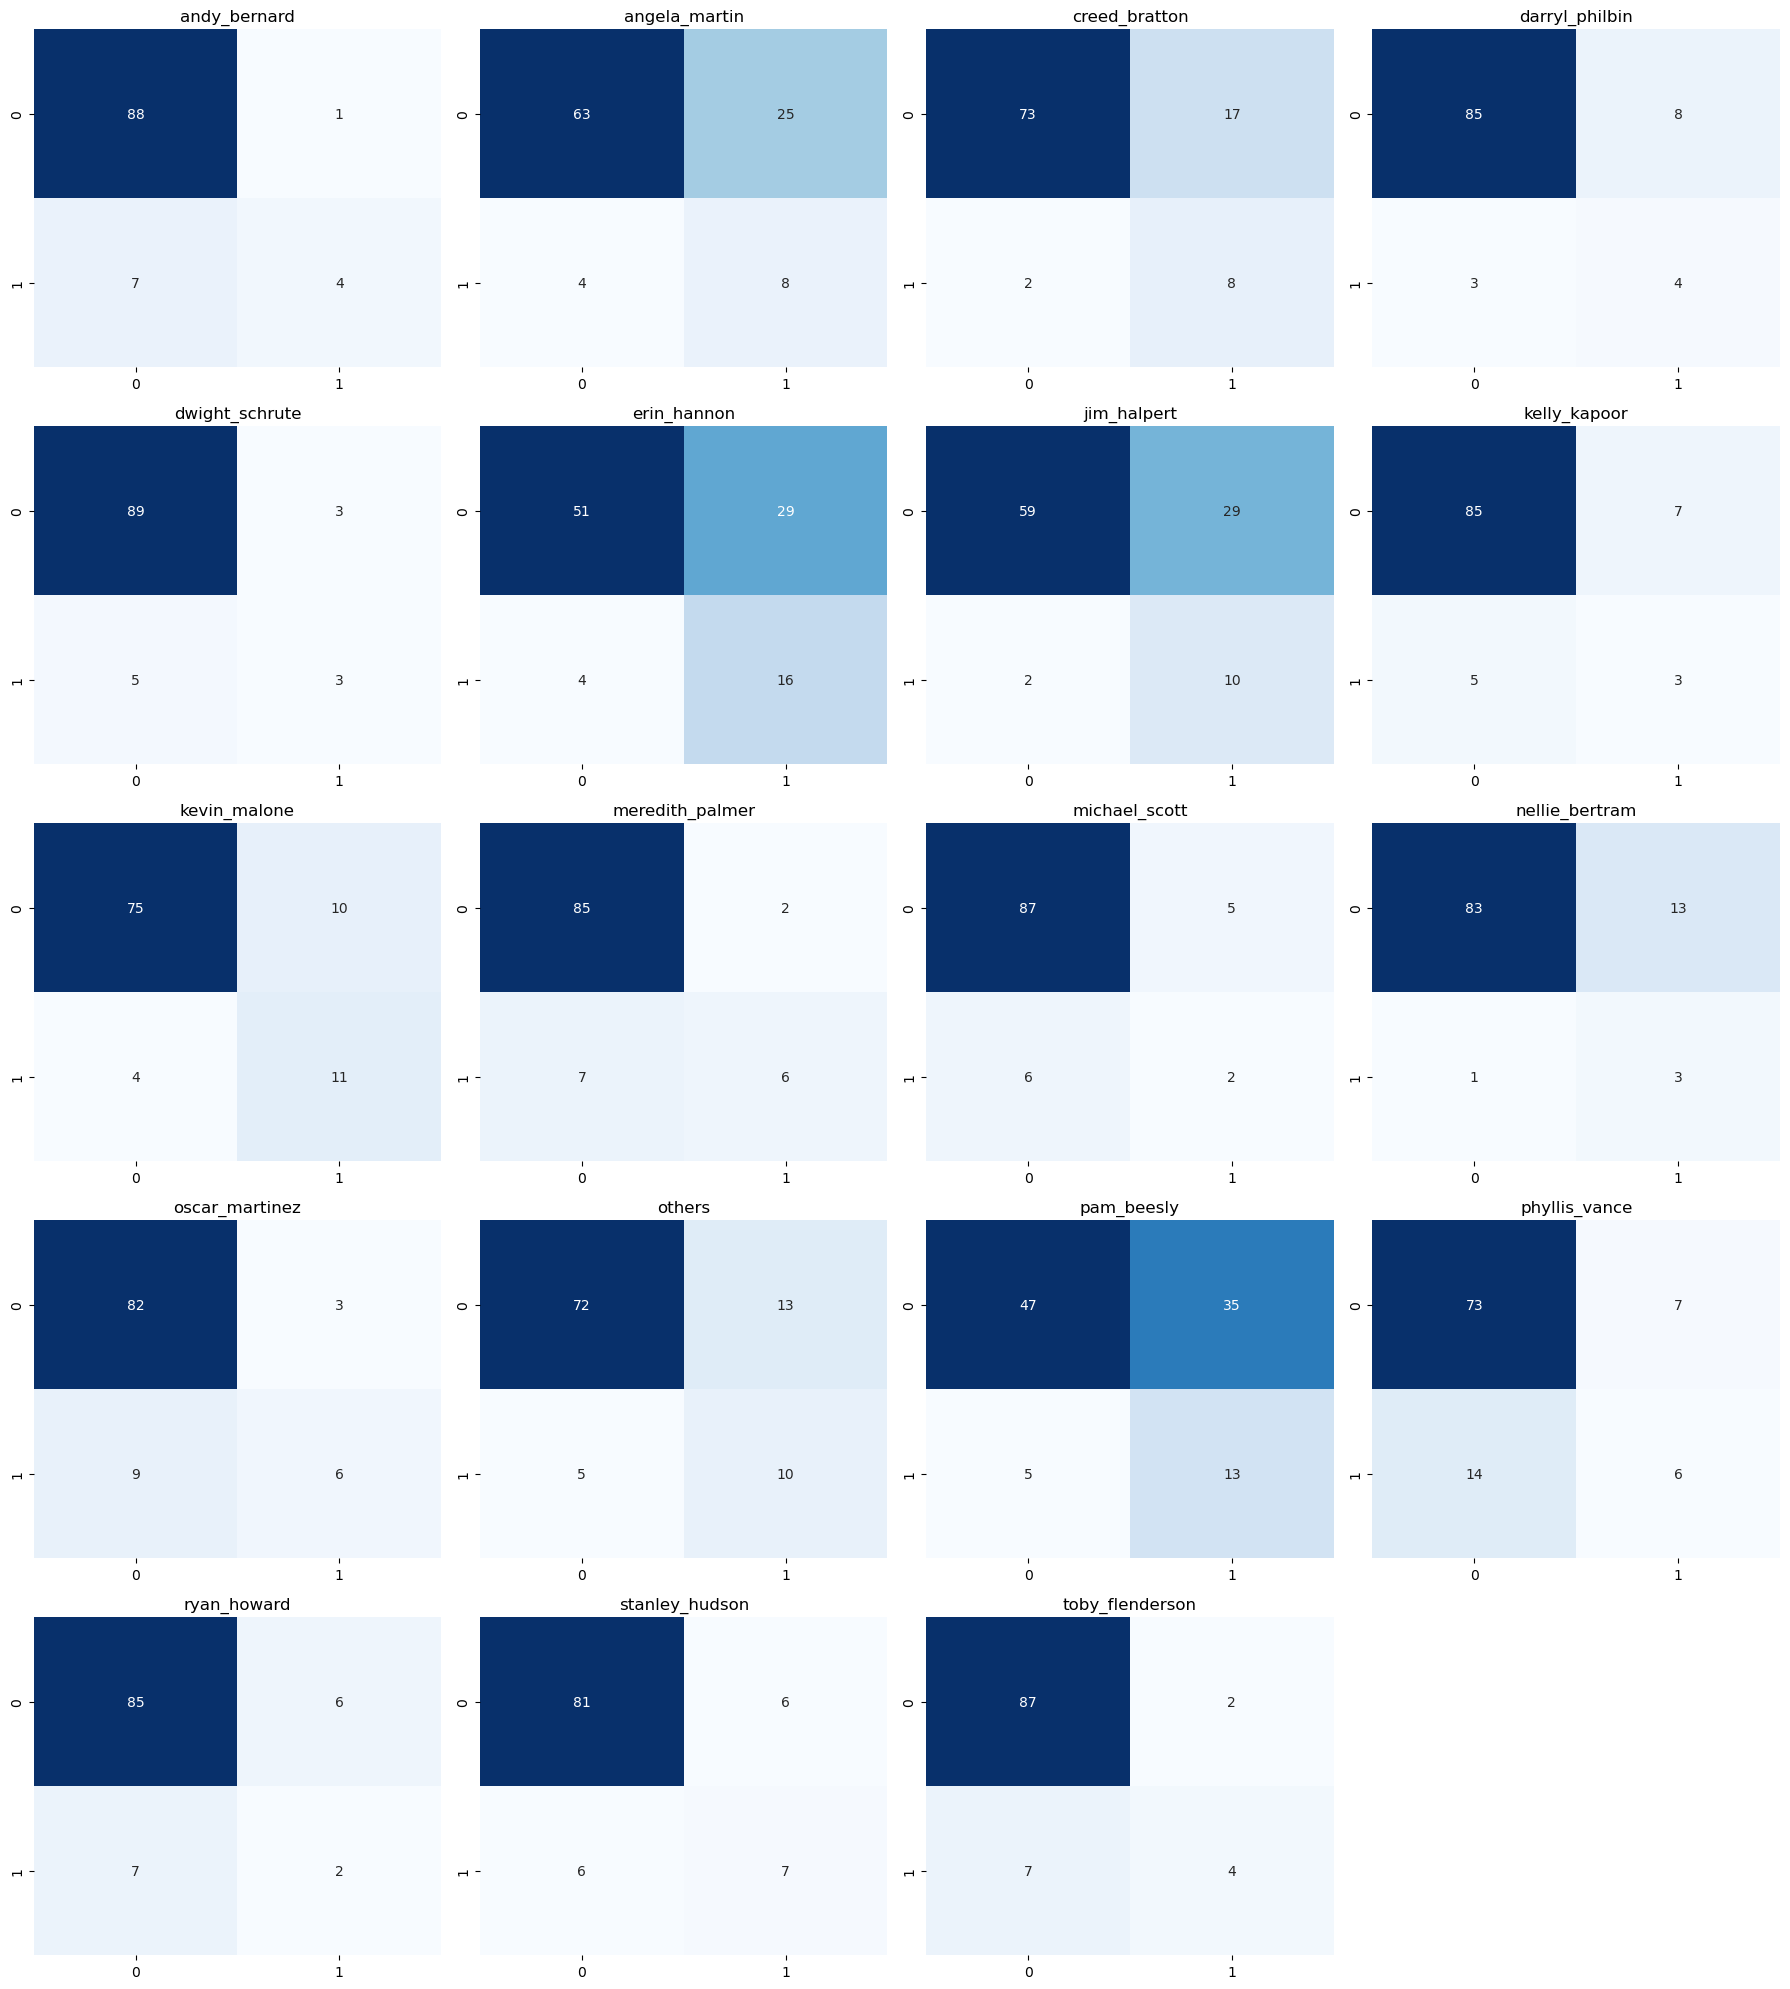

In [15]:
#Confusion Matrices (Multi-label)
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

cms = multilabel_confusion_matrix(targets, preds_opt)

fig, axes = plt.subplots(5, 4, figsize=(18, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_classes:
        sns.heatmap(cms[i], annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
        ax.set_title(list(label_map.keys())[i])
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


Running t-SNE…


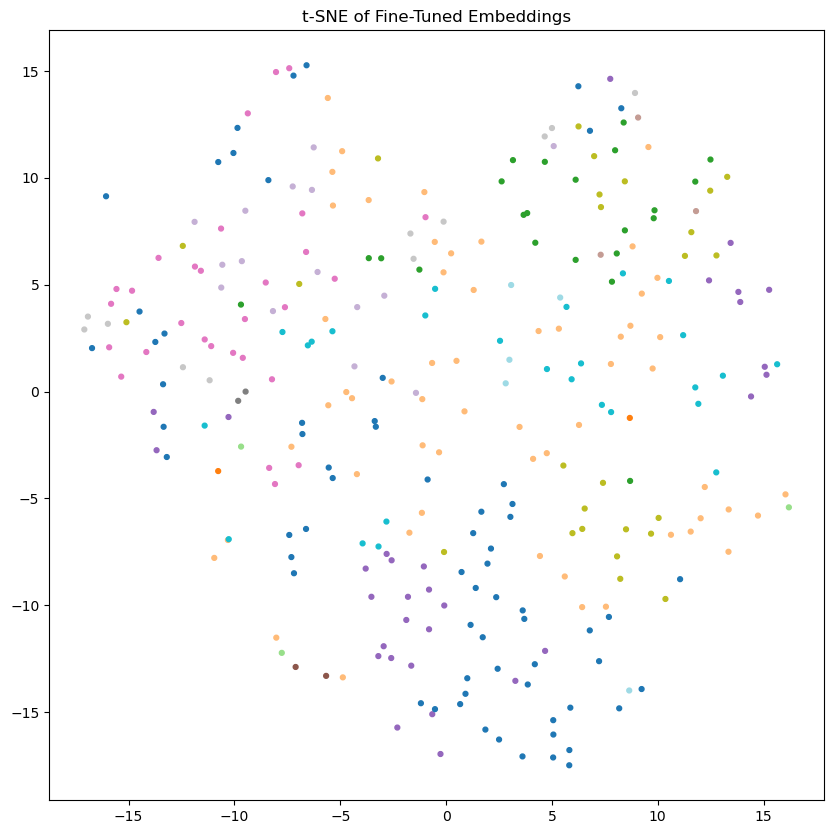

In [16]:
#t-SNE Embedding Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# sample subset
subset_idx = np.random.choice(len(train_ds), size=300, replace=False)

emb = []
labs = []

finetuned.eval()

with torch.no_grad():
    for idx in subset_idx:
        img, lab = train_ds[idx]
        
        x = img.unsqueeze(0).to(device)

        # backbone features
        feat = finetuned.backbone(x)
        if feat.ndim == 4:
            feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1,1)).reshape(1, -1)
        
        emb.append(feat.cpu().numpy().squeeze())

        # classifier logits
        logits = finetuned.classifier(feat)
        labs.append(np.argmax(logits.cpu().numpy()))

emb = np.array(emb)
labs = np.array(labs)

print("Running t-SNE…")
tsne = TSNE(n_components=2, perplexity=30, max_iter=1500)
emb2 = tsne.fit_transform(emb)

plt.figure(figsize=(10,10))
plt.scatter(emb2[:,0], emb2[:,1], c=labs, cmap="tab20", s=12)
plt.title("t-SNE of Fine-Tuned Embeddings")
plt.show()


/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running UMAP…


/home/syed-mohammed-bilal/.local/share/mamba/envs/office_ssl/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


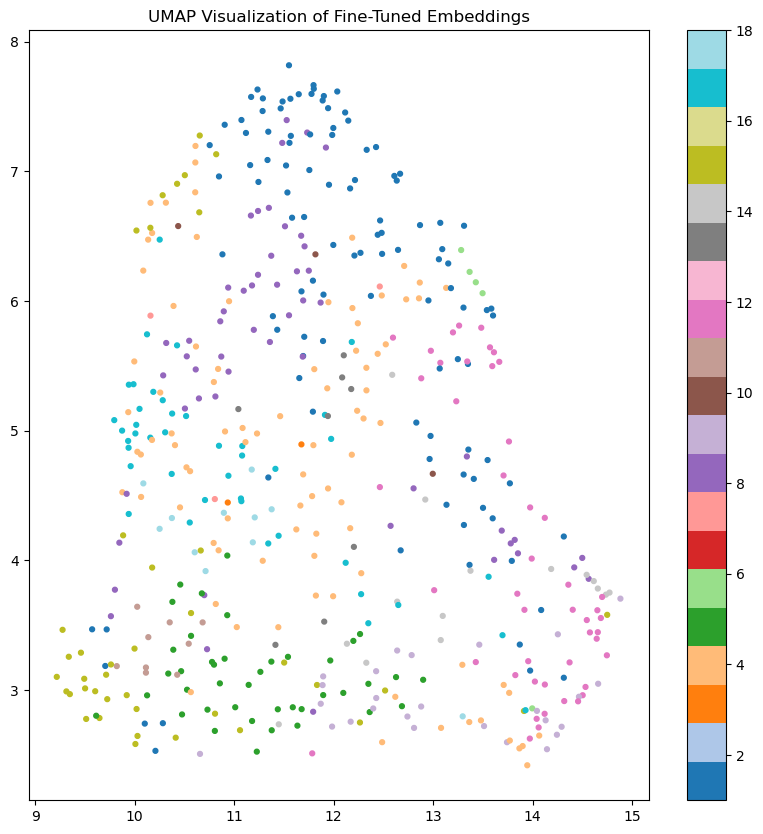

In [17]:
# UMAP Visualization of Fine-Tuned Embeddings
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import torch

subset_idx = np.random.choice(len(train_ds), size=500, replace=False)

emb = []
labs = []

finetuned.eval()

with torch.no_grad():
    for idx in subset_idx:
        img, lab = train_ds[idx]
        x = img.unsqueeze(0).to(device)

        # Backbone embeddings
        feat = finetuned.backbone(x)
        if feat.ndim == 4:
            feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1,1)).reshape(1, -1)

        emb.append(feat.cpu().numpy().squeeze())

        # Classifier logits → predicted class
        logits = finetuned.classifier(feat)
        logits = logits.cpu().numpy().squeeze()
        labs.append(np.argmax(logits))

emb = np.array(emb)
labs = np.array(labs)

print("Running UMAP…")

reducer = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42
)

emb2 = reducer.fit_transform(emb)

plt.figure(figsize=(10, 10))
plt.scatter(emb2[:, 0], emb2[:, 1], c=labs, cmap="tab20", s=12)
plt.title("UMAP Visualization of Fine-Tuned Embeddings")
plt.colorbar()
plt.show()


In [19]:
plt.savefig(FIG_DIR / "finetune_ap_bar.png", dpi=300, bbox_inches='tight')
plt.savefig(FIG_DIR / "finetune_confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.savefig(FIG_DIR / "finetune_tsne.png", dpi=300, bbox_inches='tight')
plt.savefig(FIG_DIR / "finetune_umap.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [20]:
FIG_DIR = BASE / "figures"
FIG_DIR.mkdir(exist_ok=True)
print("Saving plots to:", FIG_DIR)

Saving plots to: /home/syed-mohammed-bilal/projects/office-ssl/figures
